In [46]:
import os
%pwd  # this tell us which path we are currently working , so based on the below output path we are working under the research file
#os.getcwd()  #  but i would like to work with main ProjectML_with_MLFlow file , so for getting i step back in path inorder to enter the main project file i used this command os.chdir("../")
os.chdir("C:\datascience End to End Projects\End-to-End-Heart-Disease-Application-main")
%pwd

'C:\\datascience End to End Projects\\End-to-End-Heart-Disease-Application-main'

In [47]:
import pandas  as pd
data=pd.read_csv("artifacts\data_ingestion\Heart_csv\heart.csv") # this path i got it from the config.yaml file  from the data_validation unzip_data_dir varaible 
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [48]:
col = list(data.columns)
categorical_features = []
numerical_features = []
for i in col:
    if len(data[i].unique()) > 6:
        numerical_features.append(i)
    else:
        categorical_features.append(i)

print('Categorical Features :',*categorical_features)
print('Numerical Features :',*numerical_features)

Categorical Features : Sex ChestPainType FastingBS RestingECG ExerciseAngina ST_Slope HeartDisease
Numerical Features : Age RestingBP Cholesterol MaxHR Oldpeak


In [49]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df1 = data.copy(deep = True)

df1['Sex'] = le.fit_transform(df1['Sex'])
df1['ChestPainType'] = le.fit_transform(df1['ChestPainType'])
df1['RestingECG'] = le.fit_transform(df1['RestingECG'])
df1['ExerciseAngina'] = le.fit_transform(df1['ExerciseAngina'])
df1['ST_Slope'] = le.fit_transform(df1['ST_Slope'])

#### DataScalling

In [50]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
mms = MinMaxScaler() # Normalization
ss = StandardScaler() # Standardization

df1['Oldpeak'] = mms.fit_transform(df1[['Oldpeak']])
df1['Age'] = ss.fit_transform(df1[['Age']])
df1['RestingBP'] = ss.fit_transform(df1[['RestingBP']])
df1['Cholesterol'] = ss.fit_transform(df1[['Cholesterol']])
df1['MaxHR'] = ss.fit_transform(df1[['MaxHR']])
df1.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,-1.433140,1,1,0.410909,0.825070,0,1,1.382928,0,0.295455,2,0
1,-0.478484,0,2,1.491752,-0.171961,0,1,0.754157,0,0.409091,1,1
2,-1.751359,1,1,-0.129513,0.770188,0,2,-1.525138,0,0.295455,2,0
3,-0.584556,0,0,0.302825,0.139040,0,1,-1.132156,1,0.465909,1,1
4,0.051881,1,2,0.951331,-0.034755,0,1,-0.581981,0,0.295455,2,0


- Machine learning model does not understand the units of the values of the features. It treats the input just as a simple number but does not understand the true meaning of that value. Thus, it becomes necessary to scale the data.
Eg : Age = Years; FastingBS = mg / dl

- We have 2 options for data scaling : 1) Normalization 2) Standardization. As most of the algorithms assume the data to be normally (Gaussian) distributed, Normalization is done for features whose data does not display normal distribution and standardization is carried out for features that are normally distributed where their values are huge or very small as compared to other features.
- Normalization : Oldpeak feature is normalized as it had displayed a right skewed data distribution.
- Standardizarion : Age, RestingBP, Cholesterol and MaxHR features are scaled down because these features are normally distributed.

#### Correlation Matrix :

<Axes: >

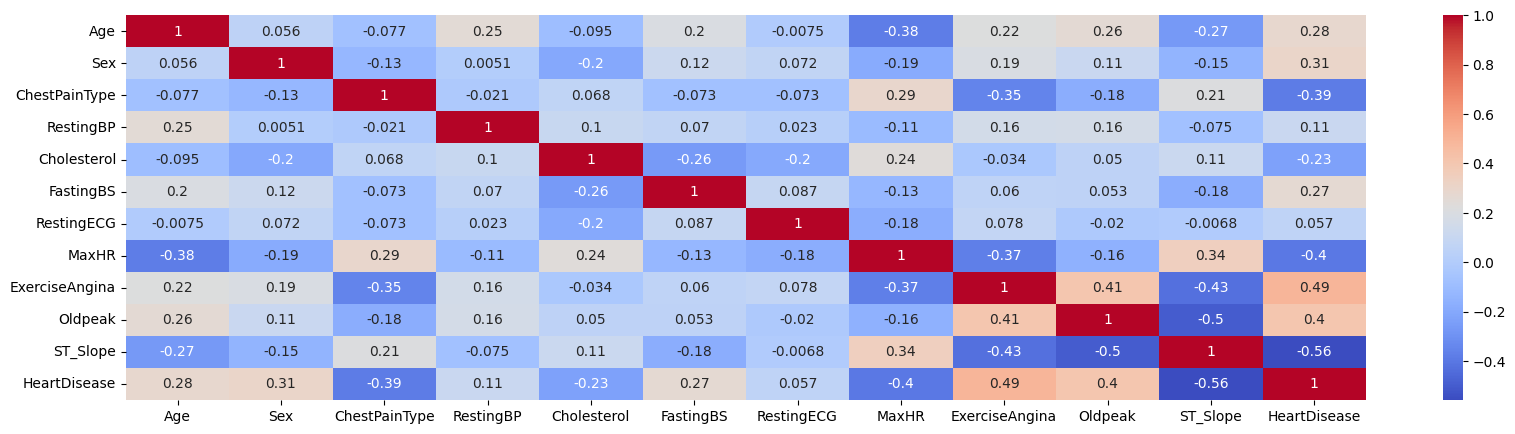

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define a list of colors for the heatmap
colors = sns.color_palette("coolwarm", as_cmap=True)

# Now you can use colors in your heatmap
plt.figure(figsize=(20, 5))
sns.heatmap(df1.corr(), cmap=colors, annot=True)


- It is a huge matrix with too many features. We will check the correlation only with respect to HeartDisease.

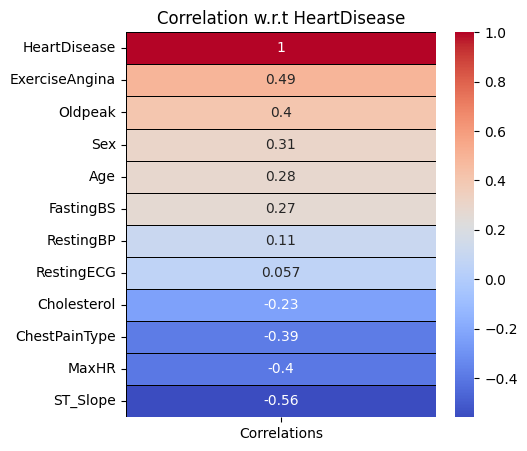

In [52]:
corr = df1.corrwith(df1['HeartDisease']).sort_values(ascending = False).to_frame()
corr.columns = ['Correlations']
plt.subplots(figsize = (5,5))
sns.heatmap(corr,annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black');
plt.title('Correlation w.r.t HeartDisease');

- Except for RestingBP and RestingECG, everyone displays a positive or negative relationship with HeartDisease.
#### Feature Selection for Categorical Features :
##### Chi Squared Test :

In [53]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

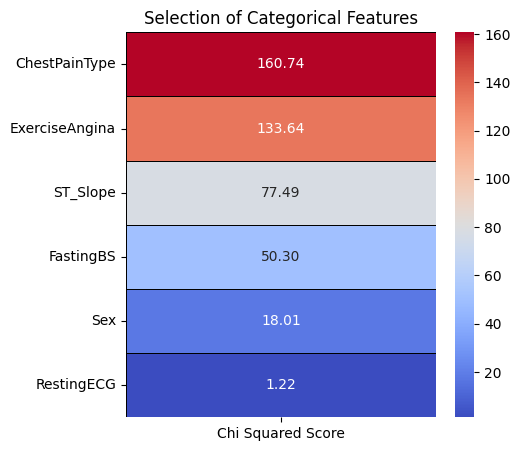

In [54]:
features = df1.loc[:,categorical_features[:-1]]
target = df1.loc[:,categorical_features[-1]]

best_features = SelectKBest(score_func = chi2,k = 'all')
fit = best_features.fit(features,target)

featureScores = pd.DataFrame(data = fit.scores_,index = list(features.columns),columns = ['Chi Squared Score']) 

plt.subplots(figsize = (5,5))
sns.heatmap(featureScores.sort_values(ascending = False,by = 'Chi Squared Score'),annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black',fmt = '.2f');
plt.title('Selection of Categorical Features');


- Except RestingECG, all the remaining categorical features are pretty important for predicting heart diseases.

####  Selection for Numerical Features :
ANOVA Test :

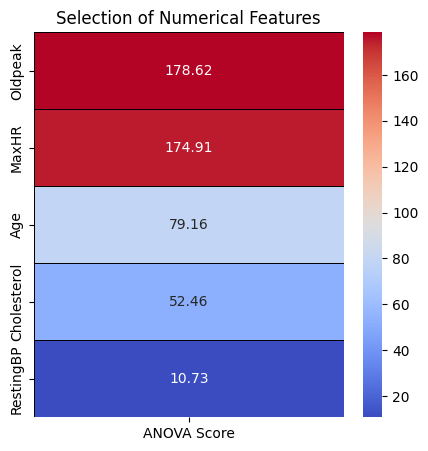

In [55]:
from sklearn.feature_selection import f_classif

features = df1.loc[:,numerical_features]
target = df1.loc[:,categorical_features[-1]]

best_features = SelectKBest(score_func = f_classif,k = 'all')
fit = best_features.fit(features,target)

featureScores = pd.DataFrame(data = fit.scores_,index = list(features.columns),columns = ['ANOVA Score']) 

plt.subplots(figsize = (5,5))
sns.heatmap(featureScores.sort_values(ascending = False,by = 'ANOVA Score'),annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black',fmt = '.2f');
plt.title('Selection of Numerical Features');

- We will leave out RestingBP from the modeling part and take the remaining features.

In [35]:
# This is called the entity 
from dataclasses import dataclass # here i imported the dataclass from the dataclasses
from pathlib import Path  # here i imported path from pathlib

@dataclass(frozen=True)
class DataTransformationConfig:
    root_dir: Path  # these are variables which are present inside the config.yaml file data_transformation code part and here iam mentioning inside the entity of the class
    data_path: Path

In [36]:
from PROJECTML.constants import *
from PROJECTML.utils.common import read_yaml, create_directories

In [37]:
# this is same part of the code in every step 
class ConfigurationManager:
    def __init__(
        self,
        config_filepath = CONFIG_FILE_PATH,
        params_filepath = PARAMS_FILE_PATH,
        schema_filepath = SCHEMA_FILE_PATH):

        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        self.schema = read_yaml(schema_filepath)

        create_directories([self.config.artifacts_root])


    # only this part get changes in every step, only defining the get_data_transformation_config get changes according to which step we are performing like 01_data_ingestion,02_data_validation
    def get_data_transformation_config(self) -> DataTransformationConfig:
        config = self.config.data_transformation

        create_directories([config.root_dir])

        data_transformation_config = DataTransformationConfig(
            root_dir=config.root_dir,  # here iam returning these 2 varaibles by using this code 
            data_path=config.data_path,
        )

        return data_transformation_config

In [38]:
import os
from PROJECTML import logger
from sklearn.model_selection import train_test_split
import pandas as pd

In [44]:
# here i defined the component of DataTransformationConfig below
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import pandas as pd


class DataTransformation:
    def __init__(self, config: DataTransformationConfig):
        self.config = config

    def label_encoding(self):
        data=pd.read_csv(self.config.data_path)
        le = LabelEncoder()
        self.df1 = data.copy(deep = True)

        self.df1['Sex'] = le.fit_transform(self.df1['Sex'])
        self.df1['ChestPainType'] = le.fit_transform(self.df1['ChestPainType'])
        self.df1['RestingECG'] = le.fit_transform(self.df1['RestingECG'])
        self.df1['ExerciseAngina'] = le.fit_transform(self.df1['ExerciseAngina'])
        self.df1['ST_Slope'] = le.fit_transform(self.df1['ST_Slope'])

    
    def data_scaling(self):
        mms = MinMaxScaler() # Normalization
        ss = StandardScaler() # Standardization

        self.df1['Oldpeak'] = mms.fit_transform( self.df1[['Oldpeak']])
        self.df1['Age'] = ss.fit_transform( self.df1[['Age']])
        self.df1['RestingBP'] = ss.fit_transform( self.df1[['RestingBP']])
        self.df1['Cholesterol'] = ss.fit_transform( self.df1[['Cholesterol']])
        self.df1['MaxHR'] = ss.fit_transform( self.df1[['MaxHR']])

        
        return self.df1

        
        
# here i have defined the tarin_test_split below for performing the train_test_split
    def train_test_spliting(self,scalled_data):


        # Split the data into training and test sets. (0.75, 0.25) split.
        train, test = train_test_split(scalled_data,test_size=0.20) # this line splits the data into train_test_split


        train.to_csv(os.path.join(self.config.root_dir, "train.csv"),index = False) # here it saves the train and test data in csv format inisde the artifacts-> transformation folder
        test.to_csv(os.path.join(self.config.root_dir, "test.csv"),index = False)

        logger.info("Splited data into training and test sets")
        logger.info(train.shape) # this logs the information about that how many training and testing samples i have 
        logger.info(test.shape)

        print(train.shape)
        print(test.shape)


In [45]:
try:
    config = ConfigurationManager() # here iam initlizing my ConfigurationManager
    data_transformation_config = config.get_data_transformation_config() # and here iam getting my get_data_transformation_config()
    data_transformation = DataTransformation(config=data_transformation_config) # here iam passing my data_transformation_config it means iam calling this data_transformation_config
    data_transformation.label_encoding()
    scalled_data=data_transformation.data_scaling()
    data_transformation.train_test_spliting(scalled_data) # here performing the train_test_split()
except Exception as e: # this part of code will raise error if anything goes wrong
    raise e

[2024-02-21 00:04:09,098: INFO: common: yaml file: config\config.yaml loaded successfully]
[2024-02-21 00:04:09,100: INFO: common: yaml file: params.yaml loaded successfully]
[2024-02-21 00:04:09,104: INFO: common: yaml file: schema.yaml loaded successfully]
[2024-02-21 00:04:09,106: INFO: common: created directory at: artifacts]
[2024-02-21 00:04:09,107: INFO: common: created directory at: artifacts/data_transformation]


[2024-02-21 00:04:09,153: INFO: 3413879274: Splited data into training and test sets]
[2024-02-21 00:04:09,154: INFO: 3413879274: (734, 12)]
[2024-02-21 00:04:09,155: INFO: 3413879274: (184, 12)]
(734, 12)
(184, 12)
